load packages and data

In [34]:
import pandas as pd
import numpy as np

df = pd.read_csv("../data/phase3_final.csv", parse_dates=["Date"], index_col="Date")

df.head()


,SPY,TLT,GLD,Regime,RegimeName,RegimeName_Shifted,Static_Return,Sp500_Return,Portfolio_Return,Cumulative_Portfolio,Cumulative_Static,Cumulative_SP500
Date,,,,,,,,,,,,
2015-01-06,-0.009464,0.017856,0.011334,2,bear,bear,0.001464,-0.009464,0.010436,1.010491,1.001466,0.990581
2015-01-07,0.012384,-0.001977,-0.005909,2,bear,bear,0.006640,0.012384,-0.000284,1.010203,1.008137,1.002925
2015-01-08,0.017590,-0.013332,-0.004217,2,bear,bear,0.005221,0.017590,-0.004413,1.005755,1.013415,1.020722
2015-01-09,-0.008046,0.010893,0.011321,1,bull,bear,-0.000470,-0.008046,0.007234,1.013057,1.012938,1.012542
2015-01-12,-0.007864,0.005706,0.011025,0,neutral,bull,-0.002436,-0.007864,-0.003261,1.009759,1.010474,1.004611


config and column sanity check

In [35]:
# config + column sanity check

ASSETS = ["SPY", "TLT", "GLD"]
REGIME_COL = "RegimeName_Shifted"
SPY_BENCH = "Sp500_Return"
S6040_BENCH = "Static_Return"

REQUIRED = ASSETS + [REGIME_COL, SPY_BENCH, S6040_BENCH]

# sort index and basic checks
df = df.sort_index().copy()
assert isinstance(df.index, pd.DatetimeIndex), "df.index must be a DateTimeIndex"

# checks for missing columns
missing = [c for c in REQUIRED if c not in df.columns]
print("Missing columns:", missing)

print("Date range:", df.index.min(), "→", df.index.max(), "| rows:", len(df))
print("Regime counts (full sample):")
print(df[REGIME_COL].value_counts(dropna=False))

print("\nAny NaNs in required columns?")
print(df[REQUIRED].isna().any())

Missing columns: []
Date range: 2015-01-06 00:00:00 → 2025-08-12 00:00:00 | rows: 2666
Regime counts (full sample):
RegimeName_Shifted
neutral    2014
bear        603
bull         49
Name: count, dtype: int64

Any NaNs in required columns?
SPY                   False
TLT                   False
GLD                   False
RegimeName_Shifted    False
Sp500_Return          False
Static_Return         False
dtype: bool


split dates into training the model to best allocate then test its returns after

In [36]:
split_date = pd.Timestamp("2018-01-01")

df_train = df.loc[df.index < split_date].copy()
df_test  = df.loc[df.index >= split_date].copy()

print("Train range:", df_train.index.min(), "→", df_train.index.max(), "| rows:", len(df_train))
print(df_train[REGIME_COL].value_counts(), "\n")

print("Test range:", df_test.index.min(), "→", df_test.index.max(), "| rows:", len(df_test))
print(df_test[REGIME_COL].value_counts())


Train range: 2015-01-06 00:00:00 → 2017-12-29 00:00:00 | rows: 753
RegimeName_Shifted
neutral    671
bear        71
bull        11
Name: count, dtype: int64 

Test range: 2018-01-02 00:00:00 → 2025-08-12 00:00:00 | rows: 1913
RegimeName_Shifted
neutral    1343
bear        532
bull         38
Name: count, dtype: int64


defines a function to track metrics- CAGR, sharpe, max drawdown

In [37]:
def metrics(log_rets, trading_days=252):
    """Given a Series of daily log returns, return key performance stats."""
    s = pd.Series(log_rets).dropna()
    if s.empty:
        return {"CAGR": None, "Sharpe": None, "MaxDD": None}
    
    avg = s.mean() * trading_days
    vol = s.std(ddof=0) * (trading_days ** 0.5) # standard deviation of log returns population
    sharpe = avg / vol if vol > 0 else None # ratio of (expected return - risk free return (0))/(std dev of returns)
    
    curve = (s.cumsum()).pipe(np.exp)  # cumulative wealth in multiplier form
    peak = np.maximum.accumulate(curve)
    maxdd = (curve / peak - 1).min()
    
    cagr = np.exp(s.sum() * (trading_days / len(s))) - 1
    
    return {"CAGR": cagr, "Sharpe": sharpe, "MaxDD": maxdd}


defines a function to backtest

In [38]:
def backtest_with_weights(frame, weights_by_regime, assets=ASSETS, regime_col=REGIME_COL, cost_bps=0.0):
    """
    frame: DataFrame with daily log returns for each asset and regime labels
    weights_by_regime: dict like {"bull": {"SPY":0.7,"TLT":0.2,"GLD":0.1}, ...}
    assets: asset column names in order
    regime_col: column name for regime labels
    cost_bps: round-trip cost per allocation change (in basis points)
    """
    # map each row's regime to the corresponding weight vector
    W = frame[regime_col].map(weights_by_regime).apply(
        lambda d: np.array([d[a] for a in assets], dtype=float)
    )
    W = np.stack(W.to_numpy())

    # asset log returns matrix
    R = frame.loc[:, assets].to_numpy(dtype=float)

    # portfolio log return before costs
    port_log = (R * W).sum(axis=1)

    # turnover cost for change in weights: adds absolute value of each change in weights together for the full change
    W_prev = np.vstack([W[0], W[:-1]])  # shift down
    turnover = np.abs(W - W_prev).sum(axis=1)  # L1 turnover
    costs = (cost_bps / 10000.0) * turnover

    port_after = port_log - costs

    return pd.Series(port_after, index=frame.index, name="Port_LogRet")


tests backtester with phase3 fixed weights

In [39]:
# Phase 3 fixed weights → backtest and summarize metrics

fixed_w = {
    "bull":   {"SPY":0.7, "TLT":0.2, "GLD":0.1},
    "neutral":{"SPY":0.5, "TLT":0.3, "GLD":0.2},
    "bear":   {"SPY":0.2, "TLT":0.5, "GLD":0.3},
}

# portfolio returns
fix_is = backtest_with_weights(df_train, fixed_w, assets=ASSETS, regime_col=REGIME_COL, cost_bps=0.0)
fix_oos = backtest_with_weights(df_test,  fixed_w, assets=ASSETS, regime_col=REGIME_COL, cost_bps=0.0)

# quick summarizer
def summarize(name_to_series):
    rows = []
    for name, s in name_to_series.items():
        m = metrics(s)
        rows.append([name, m["CAGR"], m["Sharpe"], m["MaxDD"]])
    out = pd.DataFrame(rows, columns=["Strategy","CAGR","Sharpe","MaxDD"]).set_index("Strategy")
    return out.sort_values("Sharpe", ascending=False)

print("IN-SAMPLE (train)")
display(summarize({
    "Regime-Fixed": fix_is,
    "SPY 100%":     df_train[SPY_BENCH],
    "60/40":        df_train[S6040_BENCH],
}))

print("\nOUT-OF-SAMPLE (test)")
display(summarize({
    "Regime-Fixed": fix_oos,
    "SPY 100%":     df_test[SPY_BENCH],
    "60/40":        df_test[S6040_BENCH],
}))


IN-SAMPLE (train)


,CAGR,Sharpe,MaxDD
Strategy,,,
Regime-Fixed,0.075893,1.112311,-0.081525
60/40,0.078705,1.033415,-0.081653
SPY 100%,0.120800,0.928838,-0.130229



OUT-OF-SAMPLE (test)


,CAGR,Sharpe,MaxDD
Strategy,,,
Regime-Fixed,0.101917,0.964414,-0.259003
SPY 100%,0.140521,0.663054,-0.337173
60/40,0.072169,0.552394,-0.279005


optimizes weights per regime in testing, long-only, weights sum to 1

In [40]:
from scipy.optimize import minimize

def solve_one_regime(sub_df, assets=ASSETS):
    """Optimize weights for max Sharpe in a single regime subset."""
    X = sub_df[assets].to_numpy(dtype=float)
    if len(X) < 5:
        # too few samples — fall back to equal weights
        w0 = np.array([1/len(assets)] * len(assets))
        return {a: float(w0[i]) for i, a in enumerate(assets)}

    mu = X.mean(axis=0) * 252
    cov = np.cov(X.T) * 252

    def obj(w):
        if (w < 0).any() or abs(w.sum() - 1) > 1e-6:
            return 1e6  # penalty for invalid weights
        num = w @ mu
        den = np.sqrt(max(w @ cov @ w, 1e-12))
        return - num / den  # negative Sharpe

    cons = {"type": "eq", "fun": lambda w: w.sum() - 1.0}
    bnds = [(0.0, 1.0)] * len(assets)
    w0   = np.array([1/len(assets)] * len(assets))

    out = minimize(obj, w0, method="SLSQP", bounds=bnds, constraints=[cons], options={"maxiter":500})
    w = out.x if out.success else w0
    return {a: float(w[i]) for i, a in enumerate(assets)}

# Solve for each regime in the training set
opt_weights = {}
for regime in df_train[REGIME_COL].unique():
    sub = df_train[df_train[REGIME_COL] == regime]
    opt_weights[regime] = solve_one_regime(sub, assets=ASSETS)

print("Optimized Weights by Regime:")
for r, w in opt_weights.items():
    print(f"{r}: {w}")


Optimized Weights by Regime:
bear: {'SPY': 0.08053514788060555, 'TLT': 0.4850782464764314, 'GLD': 0.4343866056429631}
bull: {'SPY': 0.37268142289587, 'TLT': 8.769247727066485e-14, 'GLD': 0.6273185771040916}
neutral: {'SPY': 0.8593078052055522, 'TLT': 0.14069219479444806, 'GLD': 0.0}


tests optimized weights for both training and testing

In [41]:
# Evaluate optimized vs fixed weights

# In-sample (train)
opt_is = backtest_with_weights(df_train, opt_weights, assets=ASSETS, regime_col=REGIME_COL, cost_bps=0.0)
fix_is = backtest_with_weights(df_train, fixed_w,   assets=ASSETS, regime_col=REGIME_COL, cost_bps=0.0)

print("IN-SAMPLE (train)")
display(summarize({
    "Regime-Opt":   opt_is,
    "Regime-Fixed": fix_is,
    "SPY 100%":     df_train[SPY_BENCH],
    "60/40":        df_train[S6040_BENCH],
}))

# Out-of-sample (test)
opt_oos = backtest_with_weights(df_test, opt_weights, assets=ASSETS, regime_col=REGIME_COL, cost_bps=0.0)
fix_oos = backtest_with_weights(df_test, fixed_w,   assets=ASSETS, regime_col=REGIME_COL, cost_bps=0.0)

print("\nOUT-OF-SAMPLE (test)")
display(summarize({
    "Regime-Opt":   opt_oos,
    "Regime-Fixed": fix_oos,
    "SPY 100%":     df_test[SPY_BENCH],
    "60/40":        df_test[S6040_BENCH],
}))


IN-SAMPLE (train)


,CAGR,Sharpe,MaxDD
Strategy,,,
Regime-Opt,0.190832,2.079173,-0.074948
Regime-Fixed,0.075893,1.112311,-0.081525
60/40,0.078705,1.033415,-0.081653
SPY 100%,0.120800,0.928838,-0.130229



OUT-OF-SAMPLE (test)


,CAGR,Sharpe,MaxDD
Strategy,,,
Regime-Opt,0.189796,1.521578,-0.256624
Regime-Fixed,0.101917,0.964414,-0.259003
SPY 100%,0.140521,0.663054,-0.337173
60/40,0.072169,0.552394,-0.279005


tests optimized edge accounting for 2 or 5 bassis points per allocation change

In [42]:
# Transaction cost robustness — test at 2 bps and 5 bps

for cost_bps in [2, 5]:
    print(f"\n=== OUT-OF-SAMPLE with {cost_bps} bps cost per allocation change ===")
    
    opt_oos_cost = backtest_with_weights(
        df_test, opt_weights, assets=ASSETS, regime_col=REGIME_COL, cost_bps=cost_bps
    )
    fix_oos_cost = backtest_with_weights(
        df_test, fixed_w, assets=ASSETS, regime_col=REGIME_COL, cost_bps=cost_bps
    )
    
    display(summarize({
        f"Regime-Opt @{cost_bps}bps": opt_oos_cost,
        f"Regime-Fixed @{cost_bps}bps": fix_oos_cost,
        "SPY 100%": df_test[SPY_BENCH],
        "60/40": df_test[S6040_BENCH],
    }))



=== OUT-OF-SAMPLE with 2 bps cost per allocation change ===


,CAGR,Sharpe,MaxDD
Strategy,,,
Regime-Opt @2bps,0.187024,1.501300,-0.257328
Regime-Fixed @2bps,0.100617,0.952689,-0.259329
SPY 100%,0.140521,0.663054,-0.337173
60/40,0.072169,0.552394,-0.279005



=== OUT-OF-SAMPLE with 5 bps cost per allocation change ===


,CAGR,Sharpe,MaxDD
Strategy,,,
Regime-Opt @5bps,0.182879,1.470765,-0.258382
Regime-Fixed @5bps,0.098670,0.935073,-0.259818
SPY 100%,0.140521,0.663054,-0.337173
60/40,0.072169,0.552394,-0.279005


final graph comparison between optimized weights used with regime switching strategy, 100% SPY, and 60/40 SPY/TLT

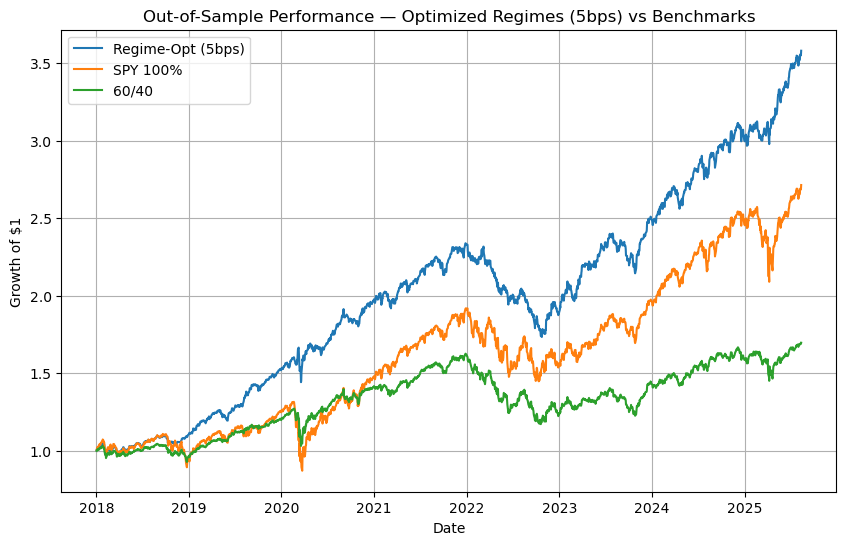

In [43]:
import matplotlib.pyplot as plt

# Build the series
opt_oos_5bps = backtest_with_weights(
    df_test, opt_weights, assets=ASSETS, regime_col=REGIME_COL, cost_bps=5
)
spy_oos = df_test[SPY_BENCH]
s6040_oos = df_test[S6040_BENCH]

# Convert log returns to cumulative growth
def equity_curve(log_rets):
    return np.exp(log_rets.cumsum())

curves = pd.DataFrame({
    "Regime-Opt (5bps)": equity_curve(opt_oos_5bps),
    "SPY 100%":          equity_curve(spy_oos),
    "60/40":             equity_curve(s6040_oos),
})

# Plot
plt.figure(figsize=(10,6))
for col in curves.columns:
    plt.plot(curves.index, curves[col], label=col)

plt.title("Out-of-Sample Performance — Optimized Regimes (5bps) vs Benchmarks")
plt.ylabel("Growth of $1")
plt.xlabel("Date")
plt.legend()
plt.grid(True)
plt.show()
